In [3]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################
epochs = 20
batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [14]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 1)

input = torch.randn(20, 16, 50, 100)
output = m(input)

print(output.shape)
print(input.shape)

torch.Size([20, 33, 50, 100])
torch.Size([20, 16, 50, 100])


In [30]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
       
        self.fc0 = nn.Conv2d(1, 16*8, 1)
        self.fc1 = nn.Conv2d(64, 32, 1)
        self.fc2 = nn.Conv2d(32, 1, 1)

    def forward(self, x):
       
        x = self.fc0(x)
        x = x.reshape(x.shape[0],64,16,16)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)        
        x = F.sigmoid(x)
        return x




class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
       
        self.fc0 = nn.Linear(1, 16)

        self.cnn0 = nn.Conv2d(8, 128, 5)

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128,2) 

    def forward(self, x):
       
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x = self.cnn0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = self.fc2(x)        
        return x



In [15]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))

# dimensions of solution space
y_dim1 = 16
y_dim2 = 16

# dimensions of measurement space
x_dim2 = 8     # no of detectors
x_dim1 = int(mes.shape[1]/x_dim2)

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_normalizer = UnitGaussianNormalizer(y_train)
#y_train = y_normalizer.encode(y_train)

#x_normalizer = UnitGaussianNormalizer(X_train)
#X_train = x_normalizer.encode(X_train)
#X_test = x_normalizer.encode(X_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_test = y_test.reshape(y_test.shape[0], 1, y_dim1,y_dim2 )
y_train = y_train.reshape(y_train.shape[0], 1, y_dim1,y_dim2 )

X_test = X_test.reshape(X_test.shape[0], 1, x_dim1,x_dim2 )
X_train = X_train.reshape(X_train.shape[0], 1, x_dim1,x_dim2 )

#batch_size = 10
#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]


print('training data: measurements', X_train.shape, 'solution', y_train.shape )
print('training data: measurements', X_test.shape, 'solution', y_test.shape )

training data: measurements torch.Size([8000, 1, 16, 8]) solution torch.Size([8000, 1, 16, 16])
training data: measurements torch.Size([2000, 1, 16, 8]) solution torch.Size([2000, 1, 16, 16])


In [17]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

In [18]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 

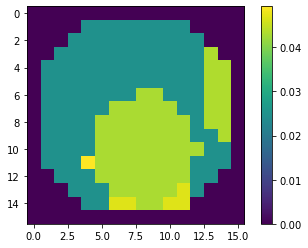

In [19]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [20]:
test_loader.dataset[test_num][0].shape 

torch.Size([1, 16, 8])

2369


c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 3.8227836000151 1.041257081091404 0.5641273362636566
1 3.553723399993032 0.5666212032437324 0.5614805161952973
2 3.539898999966681 0.5648532009720802 0.5843128724098205
3 3.556587600032799 0.56504887342453 0.5608929450511932
4 3.524258000019472 0.5644316798448563 0.569480952501297
5 3.498076800024137 0.5643869521021843 0.5615546247959137
6 3.7153579999576323 0.5645727660655976 0.5616764194965362
7 3.6293264999985695 0.565289589047432 0.5667853863239288
8 3.622134700010065 0.5648378735780716 0.5602561554908753
9 3.4800525000318885 0.5634789528846741 0.5632838168144226
10 3.5852462999755517 0.5631942209601403 0.5809985265731812
11 3.615811299998313 0.5641361424922943 0.5625123600959778
12 3.4896534000290558 0.5637580701708793 0.5664447360038757
13 3.581429699959699 0.563513345003128 0.5606061351299286
14 3.5321879999828525 0.5633416911363601 0.5622654531002045
15 3.4825271000154316 0.5636467449665069 0.562206583738327
16 3.5290655000135303 0.5622815836071968 0.5635126910209656
17 3.682

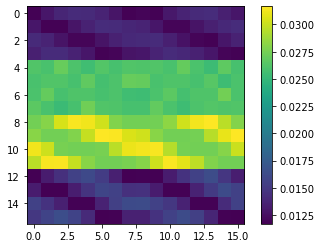

In [31]:
# SIGMA - TEST NETWORK
############################################################################

model_fcn_sigma = CNN_1().cuda()
print(count_params(model_fcn_sigma))
output_sigma = train_model(model_fcn_sigma, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_sigma_model = output_sigma.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_sigma = model_metrics(output_sigma_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_sigma_model.eval()
predicted = np.reshape(output_sigma_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [10]:
''' 
# SOFTMAX - TEST NETWORK
############################################################################

model_softmax = FCN_softmax().cuda()
print(count_params(model_softmax))
output_softmax = train_model(model_softmax, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_softmax_model = output_softmax.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_softmax = model_metrics(output_softmax_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_softmax_model.eval()
predicted = np.reshape(output_softmax_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()
'''

' \n# SOFTMAX - TEST NETWORK\n############################################################################\n\nmodel_softmax = FCN_softmax().cuda()\nprint(count_params(model_softmax))\noutput_softmax = train_model(model_softmax, 20, batch_size, learning_rate, weight_decay, step_size, gamma)\n\noutput_softmax_model = output_softmax.get("model")\n#torch.save(output_1L_model, \'fno2D_1l.h5\')\nresults_softmax = model_metrics(output_softmax_model,test_loader,ntrain)\n\n# TEST NETWORK RESULTS\n############################################################################\nK = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()\noutput_softmax_model.eval()\npredicted = np.reshape(output_softmax_model(K).detach().cpu().numpy(),(16,16))\nplt.imshow(predicted)\nplt.colorbar()\n'